 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"></ul></div>

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

%matplotlib inline

In [30]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
days_in_month = (31, 28.25, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31)

In [2]:
def read_river(river_name, ps):
    river_flow = pd.read_csv(f'{river_name}_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    river_flow['date'] = pd.to_datetime(river_flow.drop(columns='flow'))
    river_flow.set_index('date', inplace=True)
    river_flow = river_flow.drop(columns=['year', 'month', 'day'])
    if ps == 'primary':
        river_flow = river_flow.rename(columns={'flow': 'Primary River Flow'})
    elif ps == 'secondary':
        river_flow = river_flow.rename(columns={'flow': 'Secondary River Flow'})
    return river_flow

In [3]:
def read_watershed(water_shed, year):
    morrison = pd.read_excel('Copy of Flow_Mon_X_Year.xlsx', sheet_name=str(year),
                                names=['Water Year', 'Unnamed', 'area', 'total', 'Jan',
                                                   'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
                                                   'Oct', 'Nov', 'Dec'])
    waters = morrison[morrison['Water Year'] == water_shed]
    zmonths = []
    zflows = []
    for im, month in enumerate(months):
        zmonths.append(dt.datetime(year, im+1, 15))
        zflows.append(waters[month].values[0] * 1e9/86400./days_in_month[im])
    watershedflow = {'date': zmonths, 'Watershed Flow': zflows}
    df = pd.DataFrame(watershedflow)
    df.set_index('date', inplace=True)
    return df

In [93]:
Chilliwack = read_river('Alouette_Haney', 'secondary')
usesecondary = True

In [168]:
Hope = read_river('Fraser_Hope', 'primary')

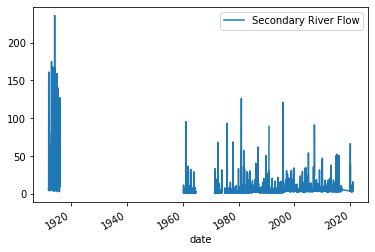

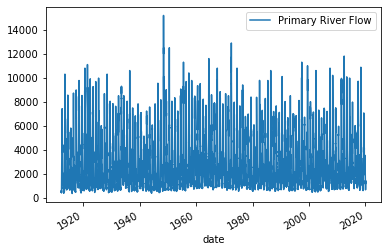

In [94]:
Chilliwack.plot();
Hope.plot();

In [95]:
diffy = Hope.index[1:] - Hope.index[:-1]
diffy_data = pd.DataFrame({'date': Hope.index[1:], 
                           'year' : Hope.index.year[1:],
                        'gap' : diffy[:]})
diffy_data = diffy_data.set_index('date')

if usesecondary:
    diffy2 = Chilliwack.index[1:] - Chilliwack.index[:-1]
    diffy2_data = pd.DataFrame({'date' : Chilliwack.index[1:],
                              'year' : Chilliwack.index.year[1:],
                              'gap' : diffy2[:]})
    diffy2_data = diffy2_data.set_index('date')

In [169]:
goodyears = []
minyear = 1970
usesecondary = False
for year in range(minyear, 2010):
    maxgap = diffy_data.gap[diffy_data.index.year == year].max()
    if usesecondary and maxgap == maxgap:
        maxgap = max(maxgap, diffy2_data.gap[diffy2_data.index.year == year].max())
    if maxgap == datetime.datetime(1980, 1, 2) - datetime.datetime(1980, 1, 1):
        if Hope['Primary River Flow'][Hope.index.year == year].shape[0] >= 365:
            if not np.isnan(Hope['Primary River Flow'][Hope.index.year == year].mean(skipna=False)):
                if usesecondary:
                    if Chilliwack['Secondary River Flow'][Chilliwack.index.year == year].shape[0] >= 365:
                        if not np.isnan(Chilliwack['Secondary River Flow'][Chilliwack.index.year == year].mean(skipna=False)):
                            goodyears.append(year)
                else:
                    goodyears.append(year)

In [170]:
print (goodyears)

[1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009]


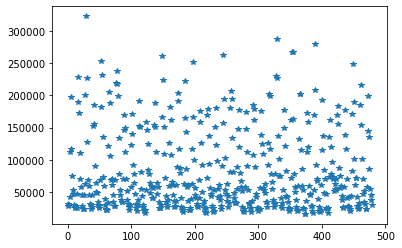

In [171]:
primary_flux = np.zeros(12*len(goodyears))
primary_daily = np.zeros(365*len(goodyears))
for i, year in enumerate(goodyears):
    for j, month in enumerate(months):
        primary_flux[i*12 + j] = (Hope['Primary River Flow'][(Hope.index.year == year) & (Hope.index.month==j+1)].mean() * 
                                   days_in_month[j])
        if primary_flux[i*12 + j] != primary_flux[i*12 + j]:
            print (year, month)
    primary_daily[i*365: (i+1)*365] = Hope['Primary River Flow'][(Hope.index.year == year)][0:365]
plt.plot(primary_flux, '*');

if usesecondary:
    secondary_flux = np.zeros(12*len(goodyears))
    secondary_daily = np.zeros(365*len(goodyears))
    for i, year in enumerate(goodyears):
        for j, month in enumerate(months):
            secondary_flux[i*12 + j] = (Chilliwack['Secondary River Flow'][(Chilliwack.index.year == year) & (Chilliwack.index.month==j+1)].mean() * 
                                   days_in_month[j])
            if secondary_flux[i*12 + j] != secondary_flux[i*12 + j]:
                print (year, month, ' secondary', secondary_flux[i*12+j])
        secondary_daily[i*365: (i+1)*365] = Chilliwack['Secondary River Flow'][(Chilliwack.index.year == year)][0:365]
    plt.plot(secondary_flux, '+');

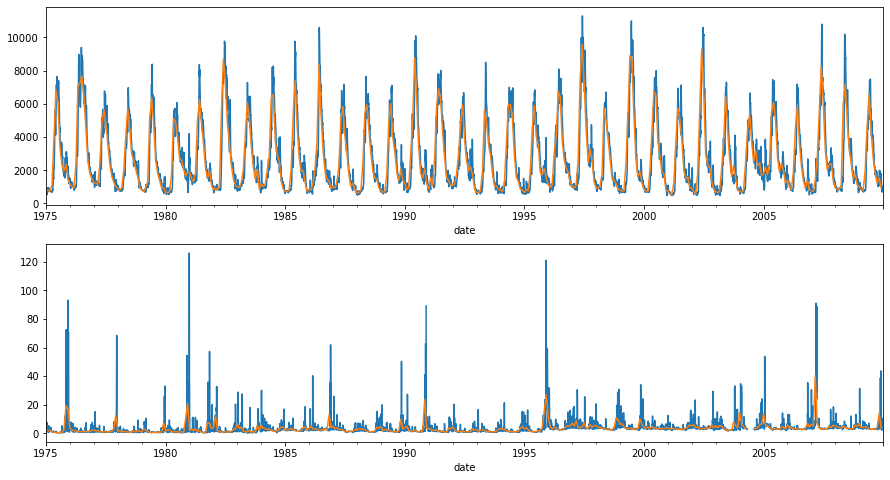

In [99]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8))
Hope[(Hope.index.year < 2010) & (Hope.index.year > 1974)]['Primary River Flow'].plot(ax=axs[0])
Hope[(Hope.index.year < 2010) & (Hope.index.year > 1974)]['Primary River Flow'].resample(
    'm').mean().plot(ax=axs[0])
if usesecondary:
    Chilliwack[(Chilliwack.index.year < 2010) & (Chilliwack.index.year > 1974)][
        'Secondary River Flow'].plot(ax=axs[1])
    Chilliwack[(Chilliwack.index.year < 2010) & (Chilliwack.index.year > 1974)][
        'Secondary River Flow'].resample(
    'm').mean().plot(ax=axs[1])

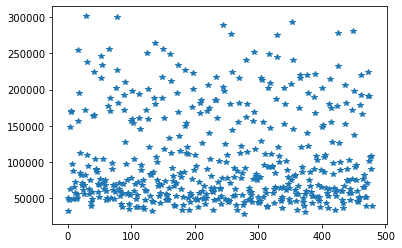

In [172]:
watershed_flux = np.zeros(12*len(goodyears))
watershed = 'Fraser'
for i, year in enumerate(goodyears):
    for j, month in enumerate(months):
        morrison = pd.read_excel('Copy of Flow_Mon_X_Year.xlsx', sheet_name=str(year),
                                names=['Water Year', 'Unnamed', 'area', 'total', 'Jan',
                                                   'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
                                                   'Oct', 'Nov', 'Dec'])
        watershed_flux[i*12 +j] = morrison[month][morrison['Water Year'] == watershed] * 1e9/86400
plt.plot(watershed_flux, '*');

In [102]:
print (len(goodyears), watershed_flux.shape, primary_flux.shape, secondary_flux.shape)

34 (408,) (408,) (408,)


(24.0, 36.0)

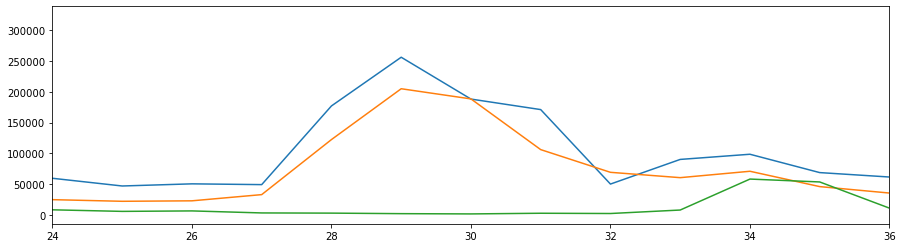

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
plt.plot(watershed_flux)
plt.plot(primary_flux)
plt.plot(secondary_flux*100);
plt.xlim(12*2, 12*3)

(24.0, 36.0)

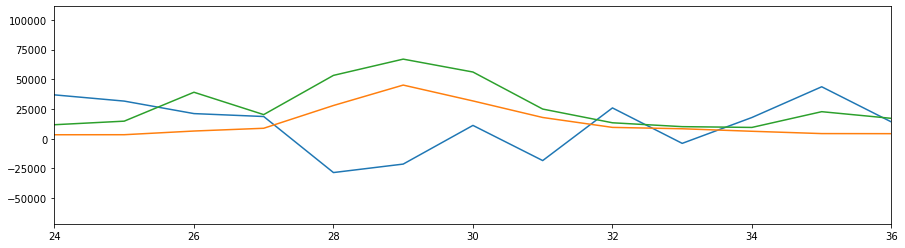

In [70]:
watershed_nothope = watershed_flux - primary_flux
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
plt.plot(watershed_nothope)
plt.plot(primary_flux*0.14)
plt.plot(secondary_flux*10);
plt.xlim(12*2, 12*3)

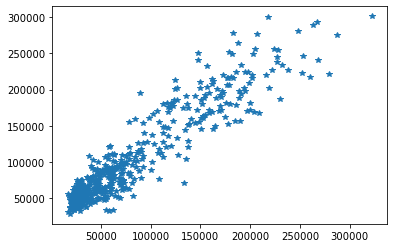

In [173]:
plt.plot(primary_flux, watershed_flux, '*');

50679.263459047885
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.948
Method:                 Least Squares   F-statistic:                              8782.
Date:                Thu, 07 Jan 2021   Prob (F-statistic):                   3.17e-310
Time:                        18:05:35   Log-Likelihood:                         -5592.1
No. Observations:                 480   AIC:                                  1.119e+04
Df Residuals:                     479   BIC:                                  1.119e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------

array([1.26663401])

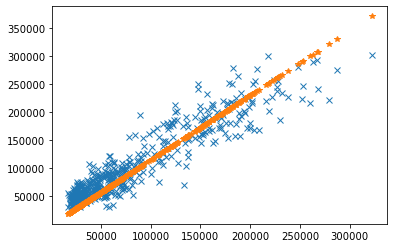

In [174]:
X = primary_flux

y = watershed_flux

# Fit and make the predictions by the model
model = sm.OLS(y, X).fit()
predictions2 = model.predict(X)
plt.plot(X, y, 'x')
plt.plot(X, predictions2,'*')
# Print out the statistics
print ((np.sqrt(((predictions2-y)**2).sum()))/12)
print(model.summary())
upit = watershed_flux.sum()/predictions2.sum()
model.params*upit

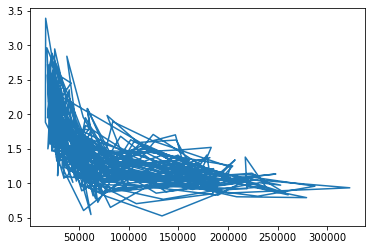

In [59]:
plt.plot(primary_flux, watershed_flux/primary_flux);

## With Nicomekl

In [112]:
Chilliwack = read_river('Nicomekl_203', 'secondary')
usesecondary = True

In [113]:
if usesecondary:
    diffy2 = Chilliwack.index[1:] - Chilliwack.index[:-1]
    diffy2_data = pd.DataFrame({'date' : Chilliwack.index[1:],
                              'year' : Chilliwack.index.year[1:],
                              'gap' : diffy2[:]})
    diffy2_data = diffy2_data.set_index('date')

In [114]:
goodyears = []
minyear = 1970
for year in range(minyear, 2010):
    maxgap = diffy_data.gap[diffy_data.index.year == year].max()
    if usesecondary and maxgap == maxgap:
        maxgap = max(maxgap, diffy2_data.gap[diffy2_data.index.year == year].max())
    if maxgap == datetime.datetime(1980, 1, 2) - datetime.datetime(1980, 1, 1):
        if Hope['Primary River Flow'][Hope.index.year == year].shape[0] >= 365:
            if not np.isnan(Hope['Primary River Flow'][Hope.index.year == year].mean(skipna=False)):
                if usesecondary:
                    if Chilliwack['Secondary River Flow'][Chilliwack.index.year == year].shape[0] >= 365:
                        if not np.isnan(Chilliwack['Secondary River Flow'][Chilliwack.index.year == year].mean(skipna=False)):
                            goodyears.append(year)
                else:
                    goodyears.append(year)

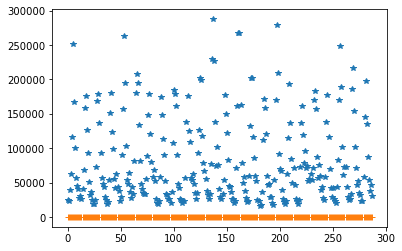

In [118]:
primary_flux = np.zeros(12*len(goodyears))
primary_daily = np.zeros(365*len(goodyears))
for i, year in enumerate(goodyears):
    for j, month in enumerate(months):
        primary_flux[i*12 + j] = (Hope['Primary River Flow'][(Hope.index.year == year) & (Hope.index.month==j+1)].mean() * 
                                   days_in_month[j])
        if primary_flux[i*12 + j] != primary_flux[i*12 + j]:
            print (year, month)
    primary_daily[i*365: (i+1)*365] = Hope['Primary River Flow'][(Hope.index.year == year)][0:365]
plt.plot(primary_flux, '*');

if usesecondary:
    secondary_flux = np.zeros(12*len(goodyears))
    secondary_daily = np.zeros(365*len(goodyears))
    for i, year in enumerate(goodyears):
        for j, month in enumerate(months):
            secondary_flux[i*12 + j] = (Chilliwack['Secondary River Flow'][(Chilliwack.index.year == year) & (Chilliwack.index.month==j+1)].mean() * 
                                   days_in_month[j])
            if secondary_flux[i*12 + j] != secondary_flux[i*12 + j]:
                print (year, month, ' secondary', secondary_flux[i*12+j])
        secondary_daily[i*365: (i+1)*365] = Chilliwack['Secondary River Flow'][(Chilliwack.index.year == year)][0:365]
    plt.plot(secondary_flux, '+');

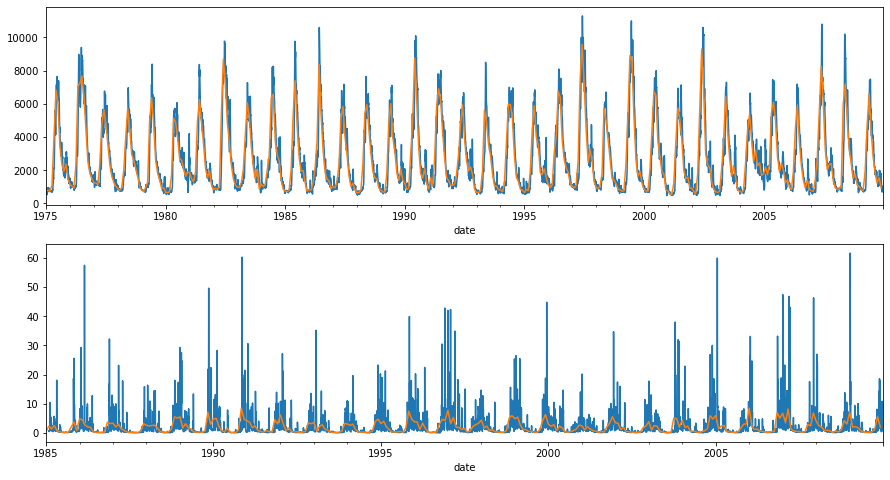

In [119]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8))
Hope[(Hope.index.year < 2010) & (Hope.index.year > 1974)]['Primary River Flow'].plot(ax=axs[0])
Hope[(Hope.index.year < 2010) & (Hope.index.year > 1974)]['Primary River Flow'].resample(
    'm').mean().plot(ax=axs[0])
if usesecondary:
    Chilliwack[(Chilliwack.index.year < 2010) & (Chilliwack.index.year > 1974)][
        'Secondary River Flow'].plot(ax=axs[1])
    Chilliwack[(Chilliwack.index.year < 2010) & (Chilliwack.index.year > 1974)][
        'Secondary River Flow'].resample(
    'm').mean().plot(ax=axs[1])

In [161]:
goodyears

[1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009]

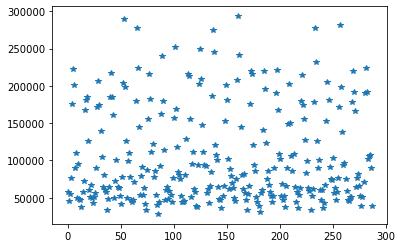

In [120]:
watershed_flux = np.zeros(12*len(goodyears))
watershed = 'Fraser'
for i, year in enumerate(goodyears):
    for j, month in enumerate(months):
        morrison = pd.read_excel('Copy of Flow_Mon_X_Year.xlsx', sheet_name=str(year),
                                names=['Water Year', 'Unnamed', 'area', 'total', 'Jan',
                                                   'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
                                                   'Oct', 'Nov', 'Dec'])
        watershed_flux[i*12 +j] = morrison[month][morrison['Water Year'] == watershed] * 1e9/86400
plt.plot(watershed_flux, '*');

17424.763888194837
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.959
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                              3363.
Date:                Wed, 06 Jan 2021   Prob (F-statistic):                   1.98e-199
Time:                        18:23:06   Log-Likelihood:                         -3321.0
No. Observations:                 288   AIC:                                      6646.
Df Residuals:                     286   BIC:                                      6653.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------

array([  1.16139158, 162.41379432])

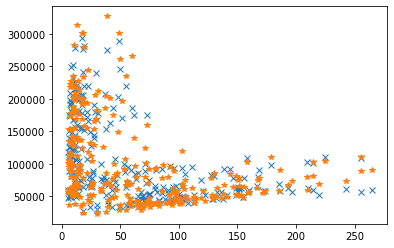

In [125]:
x = primary_flux
x2 = secondary_flux
X = np.column_stack((x, x2))
#X = sm.add_constant(X)
y = watershed_flux
# Fit and make the predictions by the model
model = sm.OLS(y, X).fit()
predictions4 = model.predict(X)
plt.plot(x2, y, 'x')
plt.plot(x2, predictions4,'*')
# Print out the statistics
print ((np.sqrt(((predictions4-y)**2).sum()))/len(goodyears))
print(model.summary())
print (predictions4.sum())
print (watershed_flux.sum())
upit = watershed_flux.sum()/predictions4.sum()
print (upit)
coeffs = model.params
coeffs*upit

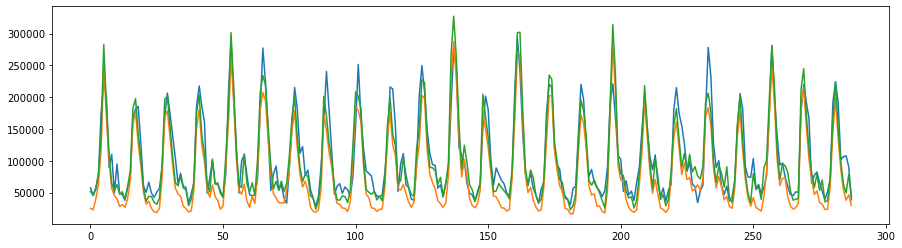

In [162]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
plt.plot(watershed_flux)
plt.plot(primary_flux)
plt.plot(predictions4);
#plt.plot(predictions4*upit);

(1.0, 12.0)

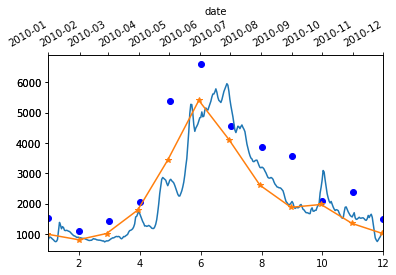

In [149]:
# Do some predictions here.
fig, ax = plt.subplots(1, 1)
year = 2010
morrison = pd.read_excel('Copy of Flow_Mon_X_Year.xlsx', sheet_name=str(year),
                                names=['Water Year', 'Unnamed', 'area', 'total', 'Jan',
                                                   'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
                                                   'Oct', 'Nov', 'Dec'])
for imonth, month in enumerate(months):
    plt.plot(imonth+1, morrison[morrison['Water Year'] == 'Fraser'][month]*1e9/86400/30.5, 'bo')
ax2=ax.twiny()
#ax2.plot(Hope[Hope.index.year==year].index, Hope[Hope.index.year==year]['Primary River Flow'])
Hope[Hope.index.year==year]['Primary River Flow'].plot(ax=ax2)
Hope[Hope.index.year==year]['Primary River Flow'].resample('M', label='left').mean().plot(ax=ax2, marker='*')
ax2.set_xlim(datetime.datetime(2010, 1, 1), datetime.datetime(2010, 12, 1))
ax.set_xlim(1, 12)

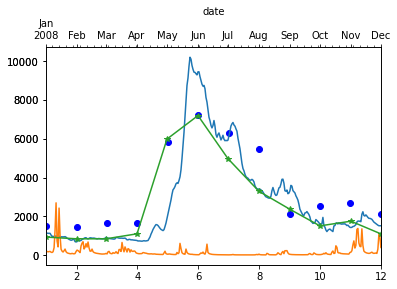

In [164]:
# Do some predictions here.
fig, ax = plt.subplots(1, 1)
year = 2008
morrison = pd.read_excel('Copy of Flow_Mon_X_Year.xlsx', sheet_name=str(year),
                                names=['Water Year', 'Unnamed', 'area', 'total', 'Jan',
                                                   'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
                                                   'Oct', 'Nov', 'Dec'])
for imonth, month in enumerate(months):
    plt.plot(imonth+1, morrison[morrison['Water Year'] == 'Fraser'][month]*1e9/86400/30.5, 'bo')
ax2=ax.twiny()
#ax2.plot(Hope[Hope.index.year==year].index, Hope[Hope.index.year==year]['Primary River Flow'])
Hope[Hope.index.year==year]['Primary River Flow'].plot(ax=ax2)
(100.*Chilliwack[Chilliwack.index.year==year]['Secondary River Flow']).plot(ax=ax2)
Hope[Hope.index.year==year]['Primary River Flow'].resample('M', label='right').mean().plot(ax=ax2, marker='*')
ax2.set_xlim(datetime.datetime(year, 1, 1), datetime.datetime(year, 12, 1))
ax.set_xlim(1, 12);

## With Alouette

15249.052670001402
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                              4352.
Date:                Sun, 03 Jan 2021   Prob (F-statistic):                   5.61e-275
Time:                        15:56:33   Log-Likelihood:                         -4721.4
No. Observations:                 408   AIC:                                      9447.
Df Residuals:                     406   BIC:                                      9455.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------

array([  1.14220035, 103.11510702])

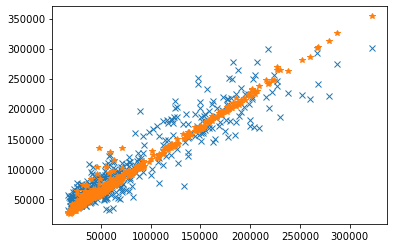

In [108]:
x = primary_flux
x2 = secondary_flux
X = np.column_stack((x, x2))
#X = sm.add_constant(X)
y = watershed_flux
# Fit and make the predictions by the model
model = sm.OLS(y, X).fit()
predictions4 = model.predict(X)
plt.plot(x, y, 'x')
plt.plot(x, predictions4,'*')
# Print out the statistics
print ((np.sqrt(((predictions4-y)**2).sum()))/len(goodyears))
print(model.summary())
print (predictions4.sum())
print (watershed_flux.sum())
upit = watershed_flux.sum()/predictions4.sum()
print (upit)
coeffs = model.params
coeffs*upit

In [110]:
### Fraser_Hope and Alouette_Haney for Fraser_not_Hope. 0.1422*Fraser + 103.11*Alouette

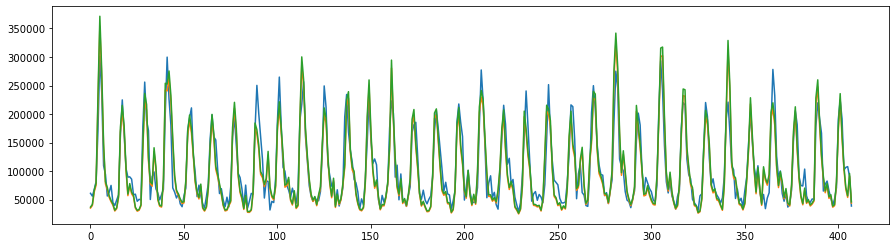

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
plt.plot(watershed_flux)
plt.plot(predictions4);
plt.plot(predictions4*upit);

15249.052670001402
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     1326.
Date:                Sun, 03 Jan 2021   Prob (F-statistic):          1.65e-178
Time:                        15:51:07   Log-Likelihood:                -4680.9
No. Observations:                 408   AIC:                             9368.
Df Residuals:                     405   BIC:                             9380.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.417e+04   2563.708 

array([2.41708362e+04, 9.57899022e-01, 1.21849086e+01])

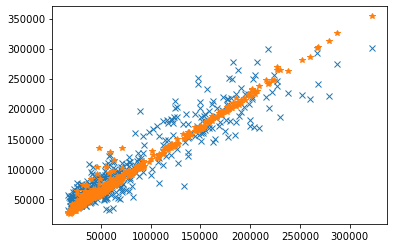

In [106]:
x = primary_flux
x2 = secondary_flux
X = np.column_stack((x, x2))
X = sm.add_constant(X)
y = watershed_flux
# Fit and make the predictions by the model
model = sm.OLS(y, X).fit()
predictions3 = model.predict(X)
plt.plot(x, y, 'x')
plt.plot(x, predictions4,'*')
# Print out the statistics
print ((np.sqrt(((predictions4-y)**2).sum()))/len(goodyears))
print(model.summary())
print (predictions3.sum())
print (watershed_flux.sum())
upit = watershed_flux.sum()/predictions4.sum()
print (upit)
coeffs = model.params
coeffs

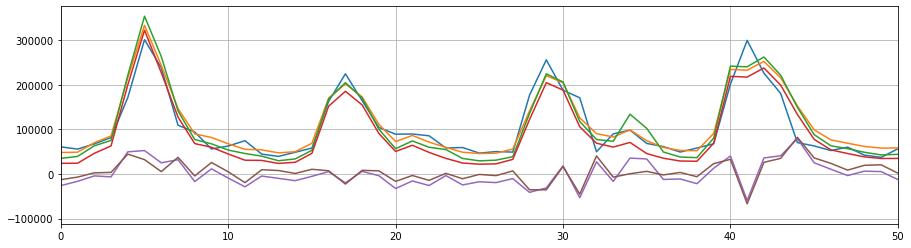

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
plt.plot(watershed_flux)
plt.plot(predictions3);
plt.plot(predictions4);
plt.plot(primary_flux)
plt.plot(predictions4 - watershed_flux)
plt.plot(predictions3 - watershed_flux)
plt.xlim(0, 50);
plt.grid();

## With Chilliwack

15895.694183235717
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                              3966.
Date:                Sun, 03 Jan 2021   Prob (F-statistic):                   3.56e-267
Time:                        15:07:24   Log-Likelihood:                         -4738.3
No. Observations:                 408   AIC:                                      9481.
Df Residuals:                     406   BIC:                                      9489.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------

array([1.00309793, 7.01452087])

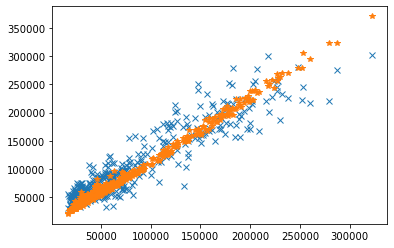

In [81]:
x = primary_flux
x2 = secondary_flux
X = np.column_stack((x, x2))
#X = sm.add_constant(X)
y = watershed_flux
# Fit and make the predictions by the model
model = sm.OLS(y, X).fit()
predictions4 = model.predict(X)
plt.plot(x, y, 'x')
plt.plot(x, predictions4,'*')
# Print out the statistics
print ((np.sqrt(((predictions4-y)**2).sum()))/len(goodyears))
print(model.summary())
print (predictions4.sum())
print (watershed_flux.sum())
upit = watershed_flux.sum()/predictions4.sum()
print (upit)
coeffs = model.params
coeffs

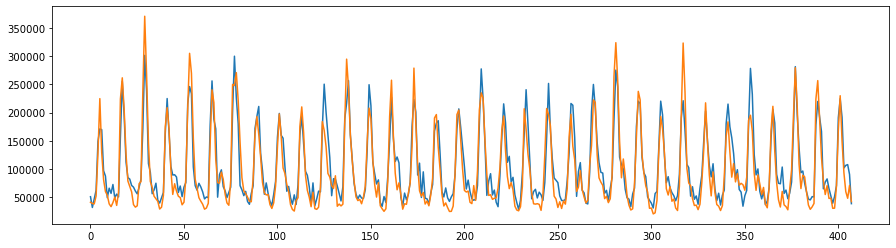

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
plt.plot(watershed_flux)
plt.plot(predictions4);

15895.694183235717
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     1399.
Date:                Sun, 03 Jan 2021   Prob (F-statistic):          1.45e-182
Time:                        15:07:34   Log-Likelihood:                -4668.2
No. Observations:                 408   AIC:                             9342.
Df Residuals:                     405   BIC:                             9354.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.796e+04   2170.296 

array([ 2.79604941e+04,  9.72842890e-01, -2.08197546e+00])

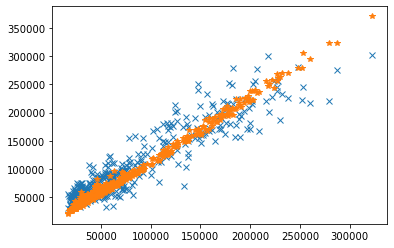

In [83]:
x = primary_flux
x2 = secondary_flux
X = np.column_stack((x, x2))
X = sm.add_constant(X)
y = watershed_flux
# Fit and make the predictions by the model
model = sm.OLS(y, X).fit()
predictions3 = model.predict(X)
plt.plot(x, y, 'x')
plt.plot(x, predictions4,'*')
# Print out the statistics
print ((np.sqrt(((predictions4-y)**2).sum()))/len(goodyears))
print(model.summary())
print (predictions3.sum())
print (watershed_flux.sum())
upit = watershed_flux.sum()/predictions4.sum()
print (upit)
coeffs = model.params
coeffs

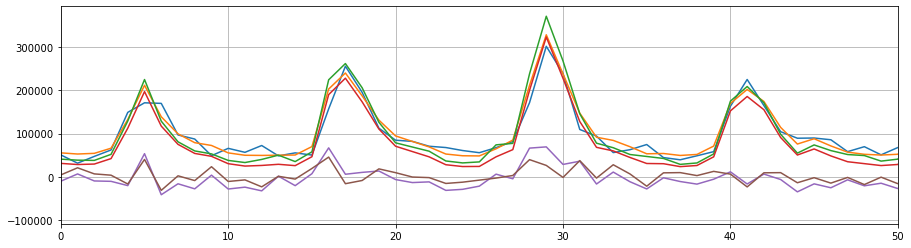

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
plt.plot(watershed_flux)
plt.plot(predictions3);
plt.plot(predictions4);
plt.plot(primary_flux)
plt.plot(predictions4 - watershed_flux)
plt.plot(predictions3 - watershed_flux)
plt.xlim(0, 50);
plt.grid();

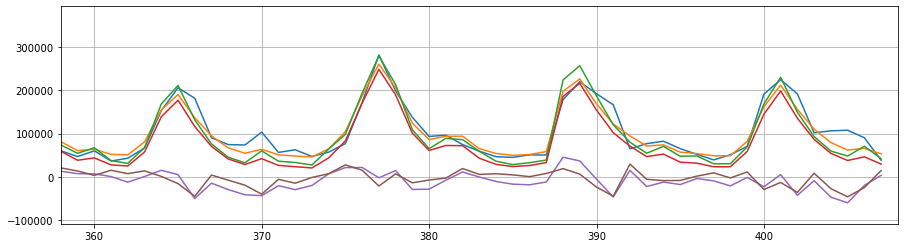

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
plt.plot(watershed_flux)
plt.plot(predictions3);
plt.plot(predictions4);
plt.plot(primary_flux)
plt.plot(predictions4 - watershed_flux)
plt.plot(predictions3 - watershed_flux)
plt.xlim(408-50, 408);
plt.grid();

In [ ]:
climFraseratHope = (931, 878, 866, 1814, 4097, 6970, 5538, 3539, 2372, 1937, 1595, 1119)
days_in_month = (31, 28.25, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31)
hope_seasonal = np.array(climFraseratHope) * np.array(days_in_month) * 86400 / 1e9

In [ ]:
plt.plot(Chilliwack_seasonal, '-*');
plt.plot(hope_seasonal, '-*')
plt.plot(watershed_seasonal);

In [ ]:
plt.plot(Chilliwack_seasonal, watershed_seasonal-hope_seasonal, '*')

In [ ]:
model = LinearRegression(fit_intercept=True)

model.fit(Chilliwack_seasonal[:, np.newaxis], watershed_seasonal-hope_seasonal)

xfit = np.linspace(0, 0.4, 10)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(Chilliwack_seasonal, watershed_seasonal-hope_seasonal)
plt.plot(xfit, yfit, 'r');

In [ ]:
X = Chilliwack_seasonal
y = watershed_seasonal-hope_seasonal

# Fit and make the predictions by the model
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

plt.plot(X, y, 'x')
plt.plot(X, predictions,'*')
# Print out the statistics
print ((np.sqrt(((predictions-y)**2).sum()))/12)
model.params

In [ ]:
# No constant
X = Chilliwack_seasonal
y = watershed_seasonal-hope_seasonal

# Fit and make the predictions by the model
model = sm.OLS(y, X).fit()
predictions2 = model.predict(X)
plt.plot(X, y, 'x')
plt.plot(X, predictions2,'*')
# Print out the statistics
print ((np.sqrt(((predictions2-y)**2).sum()))/12)
print(model.summary())
model.params

In [ ]:
X = Chilliwack_seasonal
X = sm.add_constant(X)
y = watershed_seasonal-hope_seasonal

# Fit and make the predictions by the model
model = sm.OLS(y, X).fit()
predictions2 = model.predict(X)
plt.plot(X, y, 'x')
plt.plot(X, predictions2,'*')
# Print out the statistics
print ((np.sqrt(((predictions2-y)**2).sum()))/12)
print(model.summary())
model.params

In [ ]:
plt.plot(Chilliwack_seasonal, watershed_seasonal, '*')
plt.plot(Chilliwack_seasonal, 0.793+ 9.21*Chilliwack_seasonal + hope_seasonal, 'x')

In [ ]:
otherratio = 0.016
fraserratio = 1-otherratio
other_from_Chilli = otherratio * watershed_seasonal.sum()/(watershed_seasonal.sum() - hope_seasonal.sum())

In [ ]:
fraser = hope_seasonal + (1-other_from_Chilli)*(0.793+ 9.21*Chilliwack_seasonal)
non_fraser = other_from_Chilli*(0.793+ 9.21*Chilliwack_seasonal)

In [ ]:
plt.plot(fraser)
plt.plot(hope_seasonal)
plt.plot(non_fraser);

In [166]:
1.0775780128478707*np.array([1.00309793, 7.01452087])

array([1.08091627, 7.55869346])

    for j, month in enumerate(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']):